In [1]:
# Cell 1 — Imports and parameters
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os
import re

# — USER PARAMETERS — 
session_id    = "vld_tgc_s002_ar1"
eeg_path      = f'/path/to/montage{session_id}.npy'       
met_path      = f'/path/to/meta_data/{session_id}.txt'
sampling_rate = 256                                 
segment_secs  = 5
window_size   = 29                                    

seg_len          = segment_secs * sampling_rate            # samples per segment

2025-06-05 17:36:54.658364: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-05 17:36:55.323132: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-05 17:36:56.577539: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/lclhome/umohamma/miniconda3//envs/env_chb_mit/lib/
2025-06-05 17:36:56.578105: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dl

In [2]:
def parse_metadata(metadata_path):
    seizure_times   = []
    cumulative_off  = 0.0
    prev_file_dur   = None
    start_pattern   = re.compile(r'File Start Time:\s*([\d.]+)')
    end_pattern     = re.compile(r'File End Time:\s*([\d.]+)')
    s_start_pattern = re.compile(r'Seizure Start Time:\s*([\d.]+)')
    s_end_pattern   = re.compile(r'Seizure End Time:\s*([\d.]+)')

    with open(metadata_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('File Name:'):
                # when a new file starts, accumulate the previous file's duration
                if prev_file_dur is not None:
                    cumulative_off += prev_file_dur
                prev_file_dur = None

            m = start_pattern.match(line)
            if m:
                file_start = float(m.group(1))
                continue

            m = end_pattern.match(line)
            if m:
                file_end = float(m.group(1))
                # duration = end - start (handles non-zero starts too)
                prev_file_dur = file_end - file_start
                continue

            m = s_start_pattern.match(line)
            if m:
                rel_s = float(m.group(1))
                abs_s = cumulative_off + rel_s
                seizure_times.append([abs_s, None])
                continue

            m = s_end_pattern.match(line)
            if m and seizure_times:
                rel_e = float(m.group(1))
                abs_e = cumulative_off + rel_e
                seizure_times[-1][1] = abs_e
                continue

    return [(s, e) for s, e in seizure_times if s is not None and e is not None]

seizure_times = parse_metadata(met_path)
print(seizure_times)

[(978.1667, 1029.1667)]


In [3]:
raw = np.load(eeg_path)  #
if raw.ndim != 2:
    raise ValueError(f"Expected a 2D array from {eeg_path}, got shape {raw.shape}")

expected_n_channels = 20
if raw.shape[0] == expected_n_channels and raw.shape[1] > expected_n_channels:
    eeg = raw.T
    print(f"Transposed EEG from {raw.shape} to {eeg.shape} (samples, channels).")
elif raw.shape[1] == expected_n_channels and raw.shape[0] > expected_n_channels:
    eeg = raw
    print(f"Loaded EEG with shape {eeg.shape} (samples, channels).")
else:
    raise ValueError(
        f"Cannot infer orientation: raw shape {raw.shape}, expecting one axis == {expected_n_channels}"
    )

n_samples, n_channels = eeg.shape
times = np.arange(n_samples) / sampling_rate

print(f"Final EEG: {n_samples} samples × {n_channels} channels")

tf.config.run_functions_eagerly(True)

n_segments = n_samples // seg_len
if n_segments <= 0:
    raise ValueError(
        f"EEG too short ({n_samples} samples) for at least one {segment_secs}s segment ({seg_len} samples)."
    )

segments = np.stack(
    [eeg[i*seg_len:(i+1)*seg_len, :] for i in range(n_segments)],
    axis=0
).astype(np.float32)

print(f"Segments array shape: {segments.shape}  (n_segments, seg_len, n_channels)")

X = segments
print(f"Input X shape: {X.shape}  (should match model.input_shape, e.g. (None, 1280, 20))")

Transposed EEG from (20, 1346000) to (1346000, 20) (samples, channels).
Final EEG: 1346000 samples × 20 channels
Segments array shape: (1051, 1280, 20)  (n_segments, seg_len, n_channels)
Input X shape: (1051, 1280, 20)  (should match model.input_shape, e.g. (None, 1280, 20))


In [4]:
models_dir = 'path/to/models'
pattern = re.compile(
    r"tuhszr_sngfld_unscld_unfilt_blcdet_srate256Hz_"
    r"bmrk(0[1-9]|1[0-2])_sph\d{2}m_sop\d{2}m_"
    r"seg05s_ovr00s_fold00_tuhstd_model_run00\.hdf5$"
)

all_files  = os.listdir(models_dir)
model_files = [
    fname for fname in all_files
    if pattern.match(fname)
]

model_files.sort(key=lambda fn: int(pattern.match(fn).group(1)))

models = []
for fname in model_files:
    path = os.path.join(models_dir, fname)
    print(f'Loading {fname}…')
    models.append(load_model(path))

print(f'Loaded {len(models)} models: {model_files}')

Loading tuhszr_sngfld_unscld_unfilt_blcdet_srate256Hz_bmrk01_sph02m_sop01m_seg05s_ovr00s_fold00_tuhstd_model_run00.hdf5…


2025-06-05 17:36:59.764356: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-05 17:37:01.285068: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9727 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:65:00.0, compute capability: 6.1


Loading tuhszr_sngfld_unscld_unfilt_blcdet_srate256Hz_bmrk02_sph02m_sop02m_seg05s_ovr00s_fold00_tuhstd_model_run00.hdf5…
Loading tuhszr_sngfld_unscld_unfilt_blcdet_srate256Hz_bmrk03_sph02m_sop05m_seg05s_ovr00s_fold00_tuhstd_model_run00.hdf5…
Loading tuhszr_sngfld_unscld_unfilt_blcdet_srate256Hz_bmrk04_sph05m_sop01m_seg05s_ovr00s_fold00_tuhstd_model_run00.hdf5…
Loading tuhszr_sngfld_unscld_unfilt_blcdet_srate256Hz_bmrk05_sph05m_sop02m_seg05s_ovr00s_fold00_tuhstd_model_run00.hdf5…
Loading tuhszr_sngfld_unscld_unfilt_blcdet_srate256Hz_bmrk06_sph05m_sop05m_seg05s_ovr00s_fold00_tuhstd_model_run00.hdf5…
Loading tuhszr_sngfld_unscld_unfilt_blcdet_srate256Hz_bmrk07_sph15m_sop01m_seg05s_ovr00s_fold00_tuhstd_model_run00.hdf5…
Loading tuhszr_sngfld_unscld_unfilt_blcdet_srate256Hz_bmrk08_sph15m_sop02m_seg05s_ovr00s_fold00_tuhstd_model_run00.hdf5…
Loading tuhszr_sngfld_unscld_unfilt_blcdet_srate256Hz_bmrk09_sph15m_sop05m_seg05s_ovr00s_fold00_tuhstd_model_run00.hdf5…
Loading tuhszr_sngfld_unscld_unf

In [5]:
probs = np.zeros((len(models), n_segments), dtype=np.float32)

for i, m in enumerate(models):
    print(f"\n Model {i+1}/{len(models)} expects input_shape: {m.input_shape}")
    try:
        m.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            run_eagerly=True
        )
    except Exception as e:
        print(f"compile warning: {e}")

    preds = m.predict(X, verbose=1)
    if preds.size == 0:
        raise ValueError(f"Model {i+1} returned empty predictions. Check X vs. model.input_shape.")
    probs[i, :] = preds.flatten()

print("\nAll predictions complete.")


→ Model 1/12 expects input_shape: (None, 1280, 20)


/lclhome/umohamma/miniconda3/envs/env_chb_mit/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2025-06-05 17:37:11.717973: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2025-06-05 17:37:12.481563: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


33/33 [==============================] - 3s 34ms/step

→ Model 2/12 expects input_shape: (None, 1280, 20)
33/33 [==============================] - 1s 33ms/step

→ Model 3/12 expects input_shape: (None, 1280, 20)
33/33 [==============================] - 1s 34ms/step

→ Model 4/12 expects input_shape: (None, 1280, 20)
33/33 [==============================] - 2s 51ms/step

→ Model 5/12 expects input_shape: (None, 1280, 20)
33/33 [==============================] - 2s 51ms/step

→ Model 6/12 expects input_shape: (None, 1280, 20)
33/33 [==============================] - 2s 49ms/step

→ Model 7/12 expects input_shape: (None, 1280, 20)
33/33 [==============================] - 2s 49ms/step

→ Model 8/12 expects input_shape: (None, 1280, 20)
33/33 [==============================] - 2s 51ms/step

→ Model 9/12 expects input_shape: (None, 1280, 20)
33/33 [==============================] - 2s 49ms/step

→ Model 10/12 expects input_shape: (None, 1280, 20)
33/33 [==============================] - 2s 4

In [6]:
window_size = 5

firing_power_cont = np.array([
    np.convolve(probs[i],
                np.ones(window_size)/window_size,
                mode='same')
    for i in range(len(models))
])

threshold = 0.5
binarized = (probs >= threshold).astype(np.float32)

firing_power_bin = np.array([
    np.convolve(binarized[i],
                np.ones(window_size)/window_size,
                mode='same')
    for i in range(len(models))
])

seg_times = (np.arange(n_segments)*seg_len + seg_len/2) / sampling_rate

print(f"Computed continuous FP shape: {firing_power_cont.shape}")
print(f"Computed binary FP shape: {firing_power_bin.shape}")

Computed continuous FP shape: (12, 1051)
Computed binary FP shape: (12, 1051)


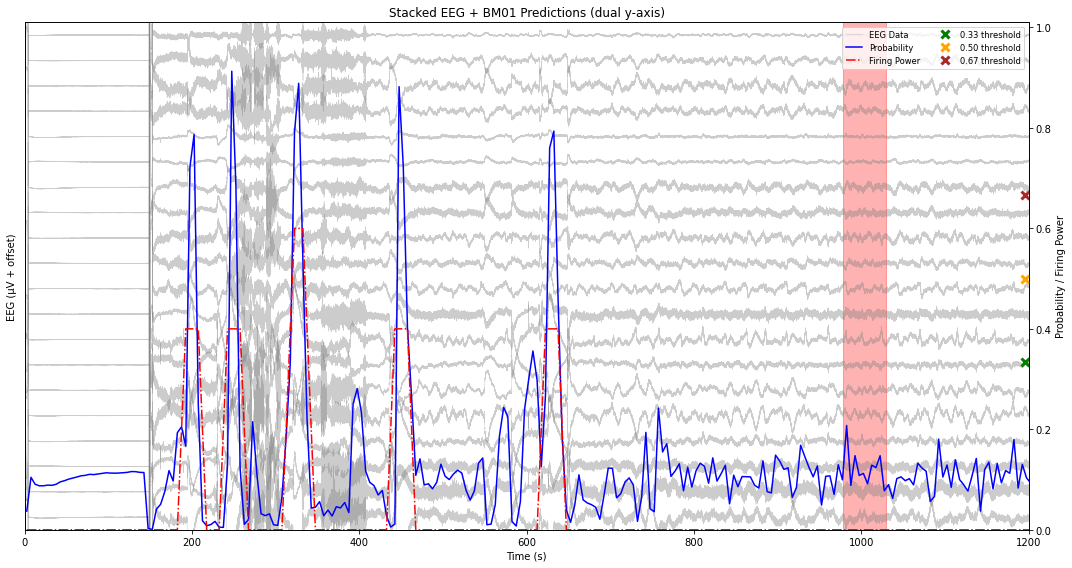

In [7]:
# choose which model to overlay (0→BM01, 1→BM02, …)
model_idx = 0

# 1) Convert EEG to microvolts
eeg_uV = eeg * 1e6  # now in µV

# 2) Derive dimensions
n_samples, n_channels = eeg_uV.shape
_, n_segments = probs.shape

# 3) Compute vertical offset for channel stacking
p2p = np.max(eeg_uV) - np.min(eeg_uV)
offset = p2p * 1.2e-2

# 4) Time axes
times = np.arange(n_samples) / sampling_rate
seg_times = np.arange(n_segments) * segment_secs + (segment_secs / 2)

# 5) Create figure and dual axes
fig, ax = plt.subplots(figsize=(15, 8))
ax2 = ax.twinx()

# 6) Plot stacked EEG on left axis
for ch in range(n_channels):
    if ch == n_channels-1:
        ax.plot(times, eeg_uV[:, ch] + ch * offset, color='grey', linewidth=0.5, alpha=0.4, label='EEG Data')
    else:
        ax.plot(times, eeg_uV[:, ch] + ch * offset, color='grey', linewidth=0.5, alpha=0.4)

# 7) Highlight seizure periods
for start, end in seizure_times:
    ax.axvspan(start, end, color='red', alpha=0.3)

# 8) Plot predictions on right axis
ax2.plot(seg_times, probs[model_idx], color="#0000FF", label='Probability')
#ax2.plot(seg_times, firing_power_cont[model_idx], color='cyan', label='Cont. FP')
ax2.plot(seg_times, firing_power_bin[model_idx], color='red', linestyle='-.', label='Firing Power')

# 9) Add horizontal threshold lines on right axis
#for thr, col in [(1/3, 'green'), (1/2, 'orange'), (2/3, 'brown')]:
#    ax2.axhline(thr, color=col, linestyle='-.', linewidth=5, label=f'{thr:.2f} threshold')
    
for thr, col in [(1/3, 'green'), (1/2, 'orange'), (2/3, 'brown')]:
    ax2.plot(1200-4, thr, color=col, linestyle='', marker = "x", markersize = 8, markeredgewidth = 3,
             linewidth=5, label=f'{thr:.2f} threshold')
    
#for thr, col in [(1/3, 'green'), (1/2, 'orange'), (2/3, 'brown')]:
#    ax2.plot([1200-4, 1200-4-100], [thr, thr], color=col, linestyle='-', 
#             marker = "x", markersize = 8, markeredgewidth = 3,
#             linewidth=5, label=f'{thr:.2f} threshold')

# 10) Axis limits
ax.set_ylim(-0.5 * offset, (n_channels - 0.5) * offset)
ax2.set_ylim(0, 1.01)

# 11) Labels, title, legend
ax.set_xlabel('Time (s)')
ax.set_ylabel('EEG (µV + offset)')
ax2.set_ylabel('Probability / Firing Power')
ax.set_yticks([])

ax.set_xlim([0, 1200])

ax.set_title(f'Stacked EEG + BM{model_idx+1:02d} Predictions (dual y-axis)')
#handles, labels = ax2.get_legend_handles_labels()
handles = ax.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
ax2.legend(handles, labels, loc='upper right', ncol=2, fontsize='small')

plt.tight_layout()

plt.savefig(f'path/to/figure/output/{session_id}_BM{model_idx+1:02d}_v05.jpeg', format='jpeg', dpi=300)
plt.show()

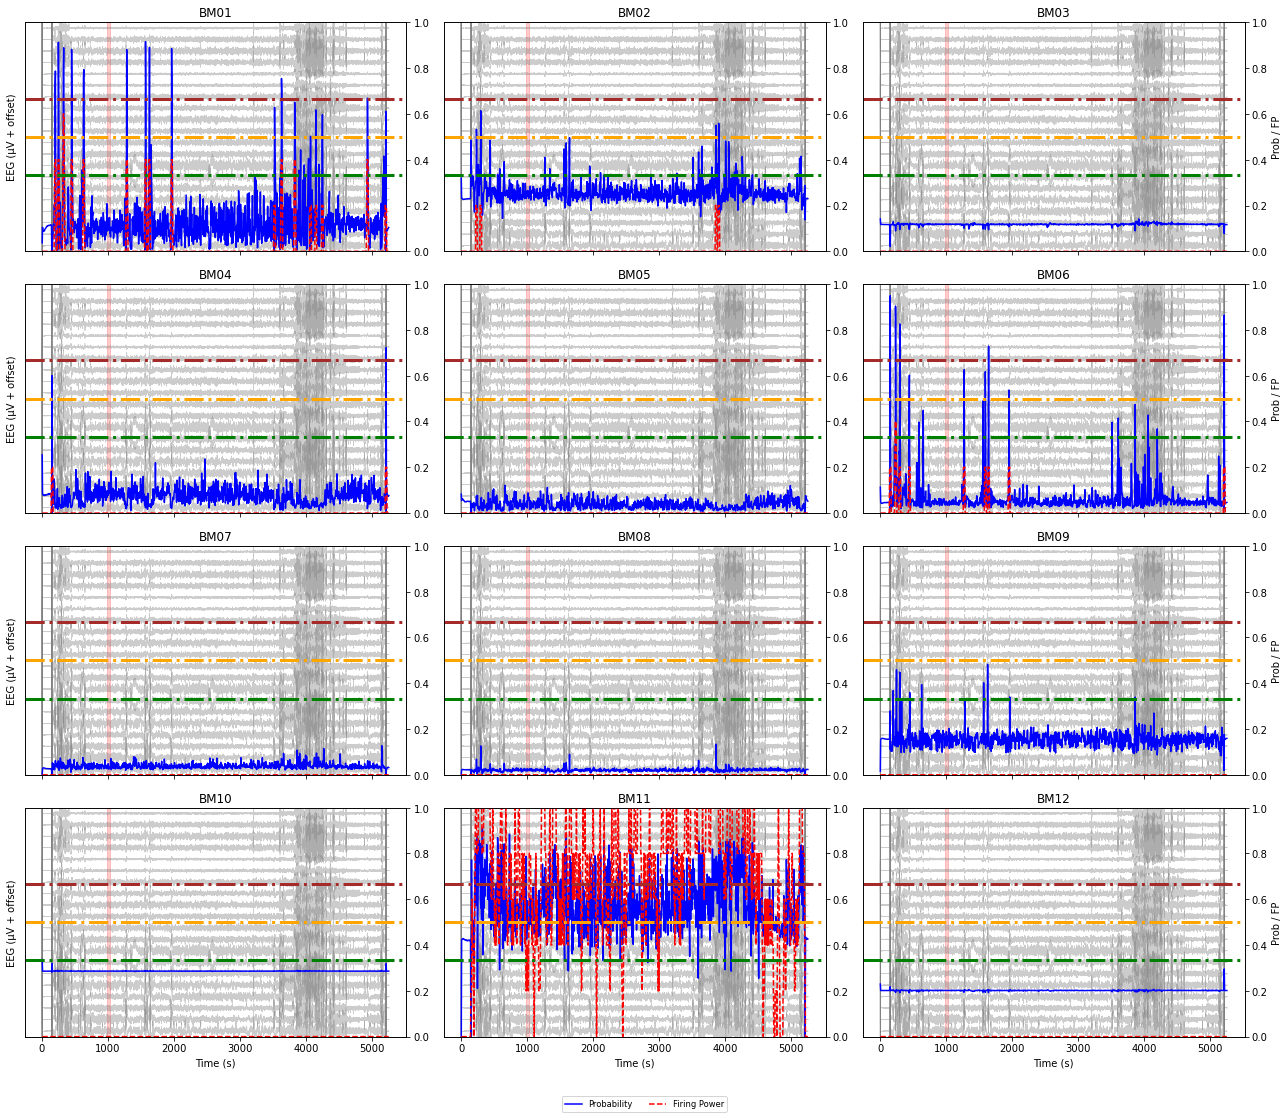

In [8]:
# 1) Prepare data (assumes these exist in your notebook)
eeg_uV            = eeg * 1e6                         # convert EEG to µV
n_samples, n_channels = eeg_uV.shape
n_models, n_segments   = probs.shape

p2p     = np.max(eeg_uV) - np.min(eeg_uV)             # peak-to-peak (µV)
offset  = p2p * 1.2e-2                                   # vertical stack spacing

times    = np.arange(n_samples) / sampling_rate       # time in seconds
seg_times = np.arange(n_segments) * segment_secs + (segment_secs/2)

# 2) Set up 4×3 subplots
fig, axes = plt.subplots(4, 3, figsize=(18, 16), sharex=True)
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= n_models:
        fig.delaxes(ax)
        continue

    ax2 = ax.twinx()
    # — stacked EEG on left axis —
    for ch in range(n_channels):
        ax.plot(times,
                eeg_uV[:, ch] + ch*offset,
                color='grey',
                linewidth=0.5,
                alpha=0.4)
    # — shade seizures —
    for start, end in seizure_times:
        ax.axvspan(start, end, color='red', alpha=0.2)

    # — predictions on right axis —
    ax2.plot(seg_times, probs[i],              color='blue',   label='Probability')
    #ax2.plot(seg_times, firing_power_cont[i],  color='cyan',   label='Cont FP')
    ax2.plot(seg_times, firing_power_bin[i],   color='red', linestyle='--', label='Firing Power')

    # — threshold lines on right axis —
    for thr, col in [(1/3, 'green'), (1/2, 'orange'), (2/3, 'brown')]:
        ax2.axhline(thr, color=col, linestyle='-.', linewidth=3)

    # — axis limits —
    ax.set_ylim(-0.5*offset, (n_channels - 0.5)*offset)
    ax2.set_ylim(0, 1)

    # — clean up & labels —
    ax.set_yticks([])           # hide EEG y-ticks
    if i % 3 == 0:
        ax.set_ylabel('EEG (µV + offset)')
    if i // 3 == 3:
        ax.set_xlabel('Time (s)')
    if i % 3 == 2:
        ax2.set_ylabel('Prob / FP')

    ax.set_title(f'BM{i+1:02d}')

# 3) Global legend for predictions & thresholds
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, fontsize='small')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig(f'path/to/figure/output/{session_id}_all_BMs.jpeg', format='jpeg', dpi=300)
plt.show()